In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [50]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [51]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors before multiplying with W --> convert (batchsz, blocksz, emd_dim) to (batchsz, blocksz*emd_dim)
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 26.5404
  10000/ 200000: 2.7673
  20000/ 200000: 2.5460
  30000/ 200000: 2.2331
  40000/ 200000: 2.3998
  50000/ 200000: 2.6874
  60000/ 200000: 2.3424
  70000/ 200000: 2.3159
  80000/ 200000: 2.1397
  90000/ 200000: 2.0194
 100000/ 200000: 2.3870
 110000/ 200000: 2.3681
 120000/ 200000: 2.2870
 130000/ 200000: 2.3650
 140000/ 200000: 2.2491
 150000/ 200000: 2.3265
 160000/ 200000: 2.1107
 170000/ 200000: 2.1445
 180000/ 200000: 2.4012
 190000/ 200000: 2.0373


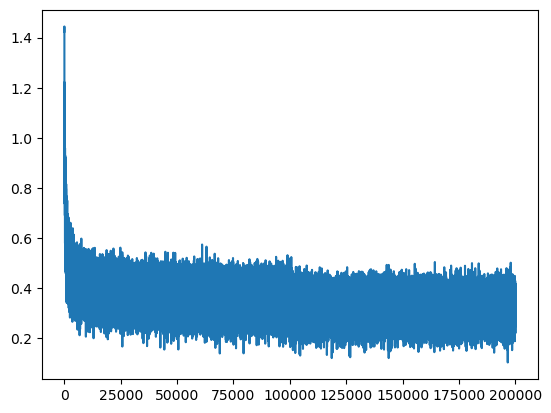

In [52]:
plt.plot(lossi)

[torch.no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad) 
Context-manager that disables gradient calculation.
Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.
In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True. 

In [53]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1190242767333984
val 2.1616098880767822


In [27]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # concatenate the vectors
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmahxa.
jahmer.
kemri.
reyton.
kanden.
jazhuel.
den.
art.
kaqui.
ner.
kentzeriiv.
kaleigh.
ham.
jorn.
quint.
saline.
livani.
waythoniearynix.
kaeliduspi.
edde.


### Fixing the inital loss

Our inital loss of `0/ 200000: 27.8817` is much higher than what we expect and decreases rapildly, this tells us that our intialization was not proper
At initialization we expect all characters prob of occuring should be roughly the same as at the start we donot have any information regarding it

In [28]:
# We expect our intial loss to be
-torch.tensor(1/27.0).log()

tensor(3.2958)

So we expect our intial loss to be roughly `3.29` which is much lower than `27.88`. This is because at intialisation our model is very confidently wrong about the probabilties of occurence of certain characters over other. Lets take an example to understand the issue

In [30]:
def loss_calc(logits):
    probs = F.softmax(logits, dim=0)
    loss = -probs[2].log()
    print(probs, loss)

# 4-dimensional example for the issue
logits1 = torch.tensor([0.0, 0.0, 0.0, 0.0]) # this is what we expect at intialisation
loss_calc(logits1)


tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)


In [31]:
logits2 = torch.tensor([0.0, 0.0, 5.0, 0.0]) # lets say we luck out and assign a high number to the correct index in this case
loss_calc(logits2) # we see a very low loss

tensor([0.0066, 0.0066, 0.9802, 0.0066]) tensor(0.0200)


In [32]:
logits3 = torch.tensor([-5.0, 6.0, 0.0, 5.0]) # what is mostly likely to happen is logits take on very high values at incorrect index and we record a very high loss
loss_calc(logits3)

tensor([1.2188e-05, 7.2973e-01, 1.8088e-03, 2.6845e-01]) tensor(6.3151)


In [37]:
logits4 = torch.randn(4) * 10
loss_calc(logits4) # now we see extremely high values of loss when we intialize randomly and a factor affects the logits

tensor([9.9741e-01, 2.5839e-03, 2.7730e-12, 7.6730e-06]) tensor(26.6111)


So we want our logits to be equal at intialization and by symmetry we need to be approx zero at start
Taking a look at our example for training the model

In [40]:
# reinitialize first before this step

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors before multiplying with W --> convert (batchsz, blocksz, emd_dim) to (batchsz, blocksz*emd_dim)
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  break

      0/ 200000: 27.8817


In [43]:
logits[0] # we see that this takes on very extreme values at initialization and causes loss to be extremely high

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9023, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward>)

Since `logits = h @ W2 + b2` we need to initialize b2 to be zero (dont want to add bias at intialization) and we want W2 to be very small so we multiply it by a small number like 0.01

In [59]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [55]:
# reinitialize first before this step

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors before multiplying with W --> convert (batchsz, blocksz, emd_dim) to (batchsz, blocksz*emd_dim)
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3148
  10000/ 200000: 2.6505
  20000/ 200000: 2.4705
  30000/ 200000: 2.0266
  40000/ 200000: 2.1797
  50000/ 200000: 2.4072
  60000/ 200000: 2.2316
  70000/ 200000: 2.0701
  80000/ 200000: 2.0010
  90000/ 200000: 2.0439
 100000/ 200000: 2.4564
 110000/ 200000: 2.2124
 120000/ 200000: 2.1843
 130000/ 200000: 2.2414
 140000/ 200000: 2.1447
 150000/ 200000: 2.2837
 160000/ 200000: 2.0286
 170000/ 200000: 2.0146
 180000/ 200000: 2.2178
 190000/ 200000: 2.0372


We see that now the loss `3.3221` is extremely close to our expected loss of `3.2958`

In [56]:
logits[0]

tensor([-5.5508,  1.7198,  0.6923,  0.7028,  0.9090,  0.6757, -0.4875,  0.0771,
         0.0704, -0.1548,  1.3755,  1.4279,  1.0340,  1.3533,  0.7785, -0.5201,
        -0.1358, -2.0231,  0.6938,  1.1193,  0.8879, -2.2990, -0.5328, -0.5378,
        -1.8165, -0.5175,  0.4151], grad_fn=<SelectBackward>)

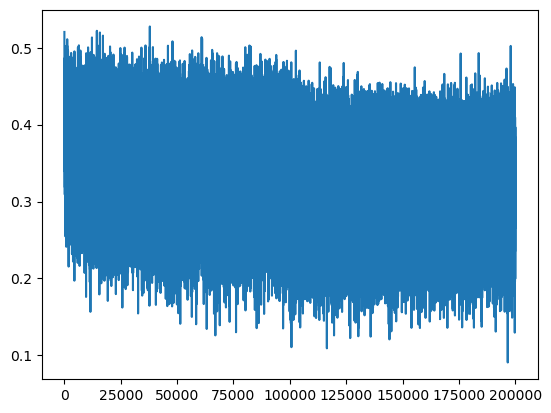

In [57]:
plt.plot(lossi)

In [58]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069324493408203
val 2.133208990097046


We observe an improvement in loss just by fixing the intial values of W2 and b2

### Fixing the saturation of tahn

There still lies a deeper problem in the intialization of our network. Lets take a look

In [60]:
# reinitialize first before this step

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors before multiplying with W --> convert (batchsz, blocksz, emd_dim) to (batchsz, blocksz*emd_dim)
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3148


In [62]:
h # we see a lot of values of h are close to 1 or -1

tensor([[ 0.9971,  0.9999, -1.0000,  ...,  0.4089, -0.9785, -1.0000],
        [ 0.2474, -0.9912,  0.9942,  ..., -0.9978,  0.7833,  0.9782],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6157, -1.0000, -0.9852],
        ...,
        [-1.0000,  0.9893, -0.9832,  ...,  0.9573,  0.8989,  1.0000],
        [ 0.1020, -0.9998,  0.6187,  ...,  0.8368, -1.0000,  0.9116],
        [-0.9993, -0.9998, -1.0000,  ..., -0.9943, -1.0000,  0.4639]],
       grad_fn=<TanhBackward>)

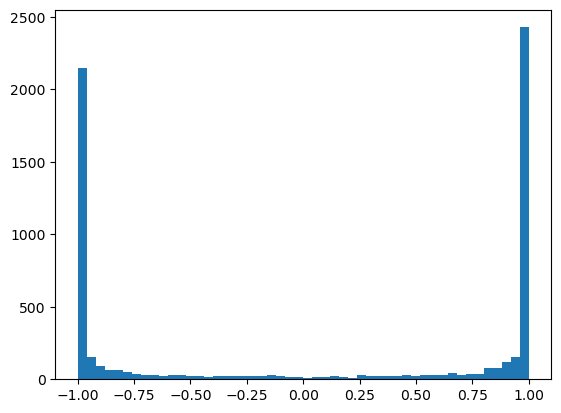

In [65]:
# taking a look at the histogram of h to see the issue
plt.hist(h.view(-1).tolist(), 50);

(array([  2.,   1.,   2.,   2.,   3.,   2.,   6.,  10.,  10.,  21.,  45.,
         53.,  70.,  78., 102., 131., 151., 199., 240., 245., 298., 285.,
        337., 356., 377., 361., 393., 341., 345., 279., 314., 266., 241.,
        156., 147., 110., 126.,  72.,  66.,  42.,  31.,  24.,  19.,  12.,
          5.,   7.,   9.,   2.,   5.,   1.]),
 array([-19.54449844, -18.76429432, -17.98409019, -17.20388607,
        -16.42368195, -15.64347782, -14.8632737 , -14.08306957,
        -13.30286545, -12.52266132, -11.7424572 , -10.96225307,
        -10.18204895,  -9.40184483,  -8.6216407 ,  -7.84143658,
         -7.06123245,  -6.28102833,  -5.5008242 ,  -4.72062008,
         -3.94041595,  -3.16021183,  -2.38000771,  -1.59980358,
         -0.81959946,  -0.03939533,   0.74080879,   1.52101292,
          2.30121704,   3.08142117,   3.86162529,   4.64182941,
          5.42203354,   6.20223766,   6.98244179,   7.76264591,
          8.54285004,   9.32305416,  10.10325829,  10.88346241,
         11.663666

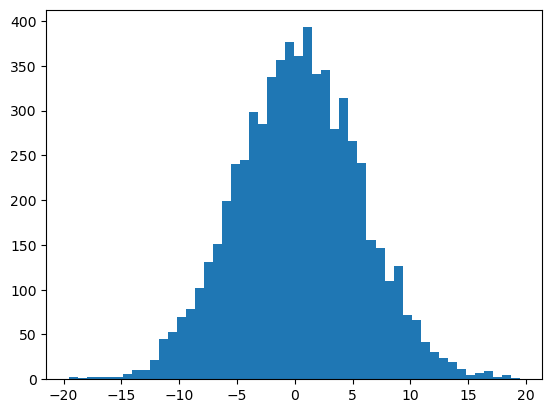

In [67]:
# taking a look at the histogram of preactivations
plt.hist(hpreact.view(-1).tolist(), 50)

We see that the preactivations are spread out. <br>
Taking a look at the tanh activation function: <br>
![tahn.png](../tanh.png)

In order to understand the issue lets take a look at how backprop is done using tanh
<br> 
We can look at our AutoGrad repo for the same ([repo link](https://github.com/himanshu3103/AutoGrad/blob/main/autograd/engine.py#L57)) <br>
`self.grad += (1 - t**2) * out.grad` here if the value of `t` is either 1 or -1 we get `self.grad = 0` therefore gradient becomes zero and this does not affect the output because it ends up in the flat region of tanh

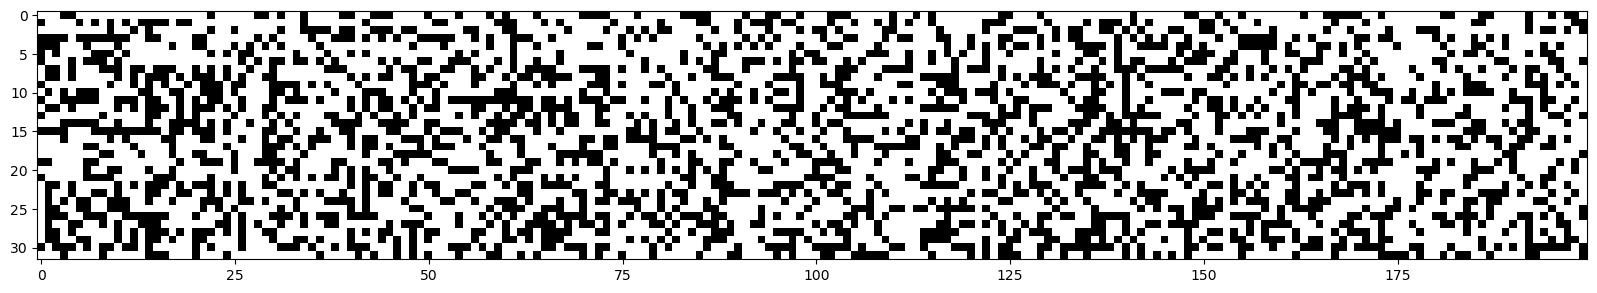

In [68]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray',interpolation='nearest')

In all the white regions the backward gradient would get destroyed. If any one of these 200 columns was completely white we would have a dead neuron. This would result in that neuron not learning as it always will fire it -1 or 1. This is not just the problem with `tanh` but also with other activation functions

![activations](../activations.png)

`Sigmoid` will suffer from the exact same issue as `tanh`. A `ReLU` neuron can get stuck in the flat region and become dead and never fire no matter what inputs are plugged in. A high enough learning rate can knock the neuron out of the data manifold and if the weights are updated such that the input to the neuron remains negative for all data points in subsequent training steps, the neuron becomes permanently inactive

We need to make the values of `hpreact` to be in a much smaller range. `hpreact = embcat @ W1 + b1 ` 

In [85]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [81]:
# reinitialize first before this step

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors before multiplying with W --> convert (batchsz, blocksz, emd_dim) to (batchsz, blocksz*emd_dim)
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3091


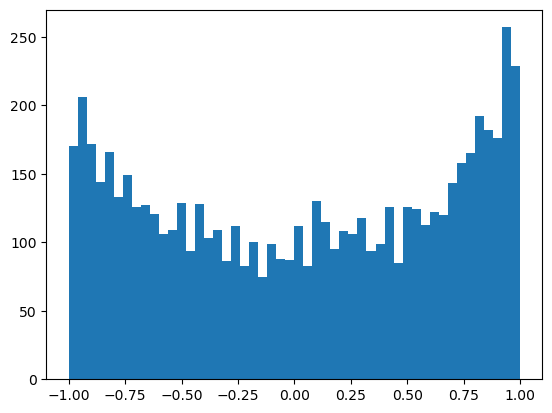

In [82]:
plt.hist(h.view(-1).tolist(), 50); # more normalized values

(array([  2.,   3.,   1.,   2.,   2.,   1.,   6.,   8.,  13.,  26.,  37.,
         35.,  57.,  90., 120., 112., 136., 205., 221., 257., 275., 321.,
        362., 351., 320., 404., 386., 358., 338., 303., 265., 272., 243.,
        192., 126., 133., 125.,  90.,  53.,  32.,  28.,  25.,  19.,  15.,
          9.,   6.,   2.,  10.,   2.,   1.]),
 array([-3.86098337, -3.70754854, -3.55411371, -3.40067888, -3.24724405,
        -3.09380922, -2.94037439, -2.78693956, -2.63350473, -2.4800699 ,
        -2.32663507, -2.17320024, -2.01976542, -1.86633059, -1.71289576,
        -1.55946093, -1.4060261 , -1.25259127, -1.09915644, -0.94572161,
        -0.79228678, -0.63885195, -0.48541712, -0.33198229, -0.17854746,
        -0.02511263,  0.1283222 ,  0.28175703,  0.43519186,  0.58862669,
         0.74206152,  0.89549635,  1.04893118,  1.20236601,  1.35580084,
         1.50923567,  1.6626705 ,  1.81610533,  1.96954016,  2.12297499,
         2.27640982,  2.42984465,  2.58327948,  2.73671431,  2.89014914,
 

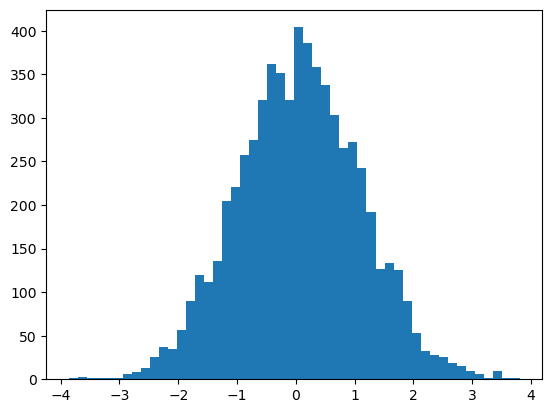

In [83]:
plt.hist(hpreact.view(-1).tolist(), 50)

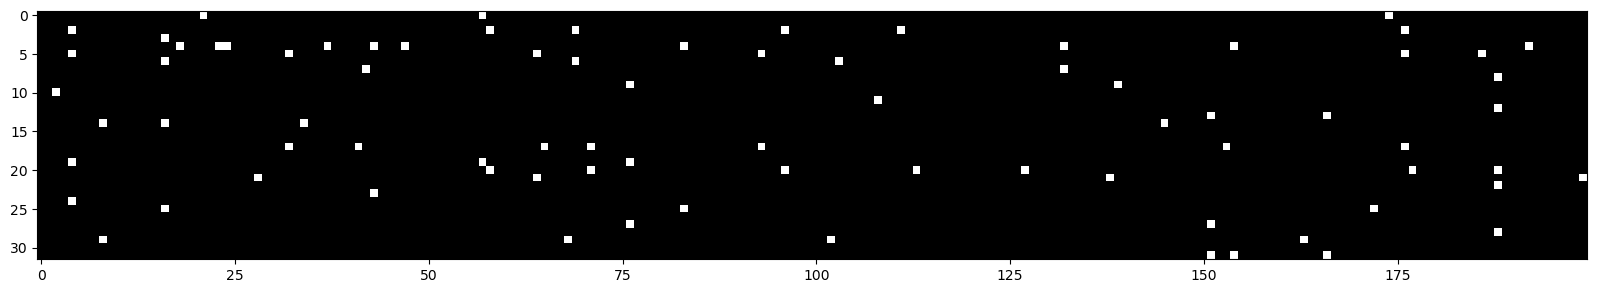

In [84]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray',interpolation='nearest')

This looks much better. We can now train the model again

In [86]:
# reinitialize first before this step

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors before multiplying with W --> convert (batchsz, blocksz, emd_dim) to (batchsz, blocksz*emd_dim)
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3091
  10000/ 200000: 2.4062
  20000/ 200000: 2.2719
  30000/ 200000: 2.0326
  40000/ 200000: 1.9983
  50000/ 200000: 2.4017
  60000/ 200000: 2.2712
  70000/ 200000: 2.0150
  80000/ 200000: 1.9887
  90000/ 200000: 2.0578
 100000/ 200000: 2.4542
 110000/ 200000: 2.1407
 120000/ 200000: 2.0326
 130000/ 200000: 2.3694
 140000/ 200000: 2.1493
 150000/ 200000: 2.3643
 160000/ 200000: 2.0745
 170000/ 200000: 2.0556
 180000/ 200000: 2.1872
 190000/ 200000: 1.8991


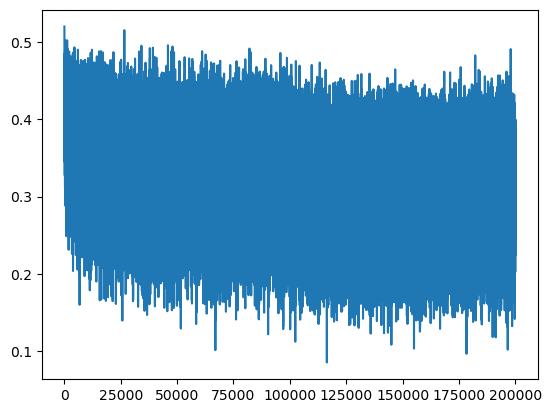

In [87]:
plt.plot(lossi)

In [88]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0343782901763916
val 2.1024086475372314


### Calculating the init scale Kaming He initialization

We don't generally set the values of initialization by hand and it can be a complex optimization problem for a deeper neural network

tensor(0.0002) tensor(0.9974)
tensor(-0.0070) tensor(5.5053)


(array([4.47274672e-06, 0.00000000e+00, 0.00000000e+00, 8.94549345e-06,
        4.47274672e-06, 1.78909869e-05, 2.23637336e-05, 5.36729607e-05,
        5.36729607e-05, 1.34182402e-04, 2.41528323e-04, 3.57819738e-04,
        7.60366943e-04, 1.21658711e-03, 2.09324547e-03, 3.42165124e-03,
        5.25547740e-03, 7.93017994e-03, 1.17007054e-02, 1.69517101e-02,
        2.28467903e-02, 3.08664251e-02, 3.94630444e-02, 4.89676311e-02,
        5.77342147e-02, 6.51097741e-02, 7.17920577e-02, 7.42073409e-02,
        7.37198115e-02, 6.97167032e-02, 6.40944606e-02, 5.41917993e-02,
        4.54744160e-02, 3.52676079e-02, 2.75342288e-02, 2.05209620e-02,
        1.44827539e-02, 1.01799715e-02, 6.36471859e-03, 4.33409158e-03,
        3.03699503e-03, 1.83829890e-03, 1.10924119e-03, 6.70912009e-04,
        3.13092271e-04, 2.28110083e-04, 1.16291415e-04, 8.49821878e-05,
        3.57819738e-05, 1.78909869e-05]),
 array([-31.09217644, -29.97429512, -28.8564138 , -27.73853249,
        -26.62065117, -25.5027

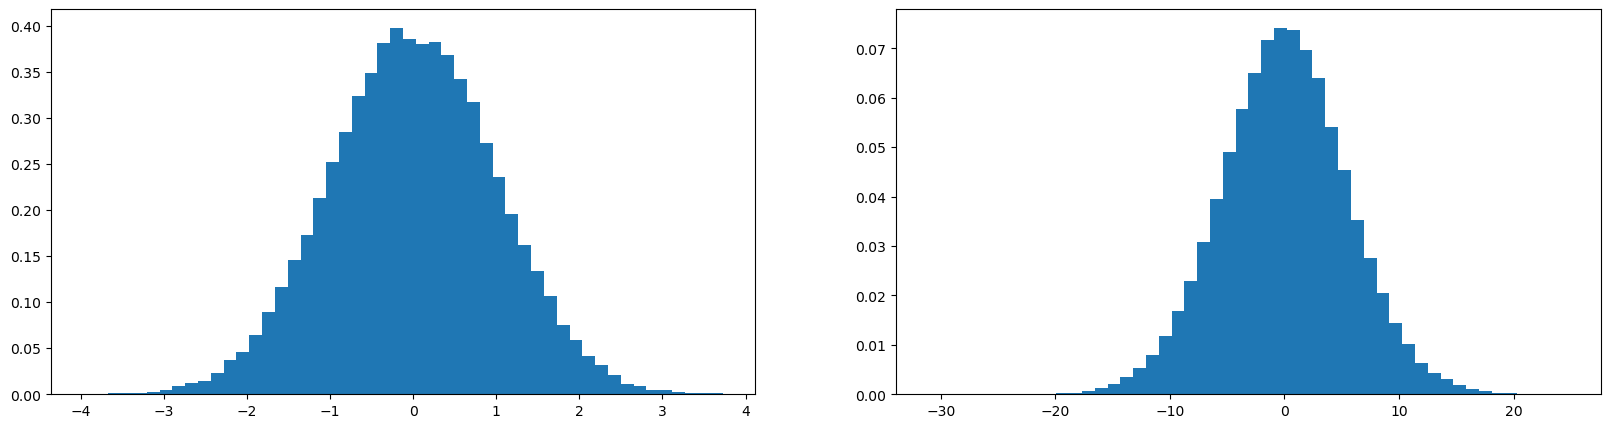

In [91]:
x = torch.randn(1000, 30)
w = torch.randn(30, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
# we note that even though the mean of the preactivation is still around the zero, the std has increased to 5.45 and we donot want that

Inorder the preserve the std to be `1` we need to divide the `w` matrix with the sqaure root of fanin

tensor(-0.0045) tensor(0.9970)
tensor(-0.0010) tensor(1.0027)


(array([7.24567186e-05, 7.24567186e-05, 1.69065677e-04, 6.52110467e-04,
        9.17785102e-04, 1.37667765e-03, 2.60844187e-03, 4.10588072e-03,
        7.31812858e-03, 1.24625556e-02, 1.90802692e-02, 2.98521681e-02,
        4.54062103e-02, 6.44623273e-02, 9.49666058e-02, 1.33827559e-01,
        1.76118131e-01, 2.25895896e-01, 2.80673175e-01, 3.29750526e-01,
        3.69480960e-01, 4.01724200e-01, 4.07399976e-01, 3.99719564e-01,
        3.69166981e-01, 3.36754676e-01, 2.79731238e-01, 2.29156449e-01,
        1.79692662e-01, 1.35494064e-01, 9.81063969e-02, 6.76021184e-02,
        4.64447566e-02, 3.07216487e-02, 1.92010304e-02, 1.21727287e-02,
        7.60795545e-03, 4.56477327e-03, 2.31861499e-03, 1.40082989e-03,
        1.06269854e-03, 4.58892551e-04, 3.38131353e-04, 1.20761198e-04,
        7.24567186e-05, 4.83044790e-05, 0.00000000e+00, 2.41522395e-05,
        0.00000000e+00, 7.24567186e-05]),
 array([-4.66537142, -4.45835128, -4.25133114, -4.044311  , -3.83729086,
        -3.63027072, 

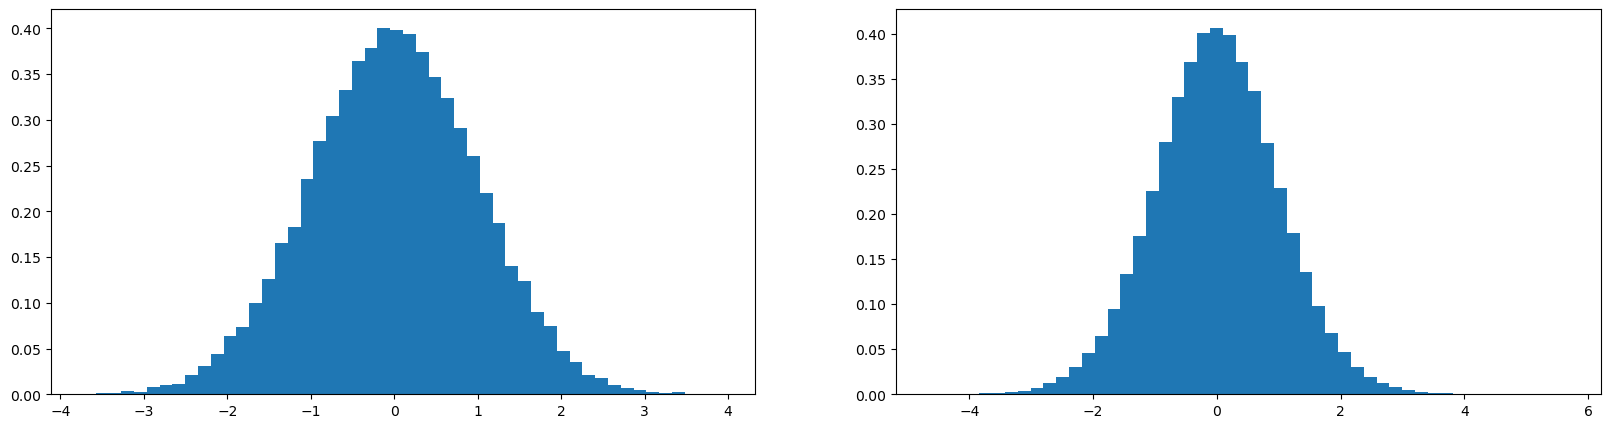

In [92]:
x = torch.randn(1000, 30)
w = torch.randn(30, 200) / (30**0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

One of the most influential papers that looks at the intialization of the weight matrices is `Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification He et al (2015)` 
<br> This intialization is also present in torch.nn.init ([torch.nn.init.kaiming_normal](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)) <br>
Based on the different non-linearity there is a different gain: ([torch.nn.init.calculate_gain](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain)) for tanh the gain is (5/3)
<br> So we need to intialize our weight by mulitpying by (5/3) / (fanin ** 0.5)

In [95]:
((5/3) / (n_embd*block_size)**0.5)

0.3042903097250923

In [97]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [98]:
# reinitialize first before this step
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors before multiplying with W --> convert (batchsz, blocksz, emd_dim) to (batchsz, blocksz*emd_dim)
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3129
  10000/ 200000: 2.4228
  20000/ 200000: 2.3509
  30000/ 200000: 2.0158
  40000/ 200000: 2.0766
  50000/ 200000: 2.3837
  60000/ 200000: 2.2647
  70000/ 200000: 2.0855
  80000/ 200000: 1.9400
  90000/ 200000: 2.0193
 100000/ 200000: 2.4169
 110000/ 200000: 2.2000
 120000/ 200000: 2.0957
 130000/ 200000: 2.2537
 140000/ 200000: 2.0838
 150000/ 200000: 2.2849
 160000/ 200000: 2.0624
 170000/ 200000: 2.0430
 180000/ 200000: 2.2258
 190000/ 200000: 1.8990


In [99]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.037754774093628
val 2.1032512187957764


We get roughly the same loss as before but now we did not have to introduce any magic numbers by looking at the histograms of std deviations and means

### Batch Normalization

In modern training the exact setting of the intial weights is not that important and one of the main reasons for that is batch normalization
<br> `Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift Ioffe et al (2015)`

We want our preactivations hpreact to be roughly gaussian, the idea introduced by the paper suggested that we can just normalize it and make it gaussian

In [105]:
hpreact.shape

torch.Size([32, 200])

In [104]:
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [106]:
hpreact.std(dim=0, keepdim=True).shape

torch.Size([1, 200])

![batch_norm](../batch_norm.png)

In [111]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12297


In [112]:
# reinitialize first before this step
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors before multiplying with W --> convert (batchsz, blocksz, emd_dim) to (batchsz, blocksz*emd_dim)
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = bngain * ((hpreact - hpreact.mean(dim=0, keepdim=True)) / (hpreact.std(dim=0, keepdim=True))) + bnbias
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3014
  10000/ 200000: 2.4789
  20000/ 200000: 2.3364
  30000/ 200000: 2.1072
  40000/ 200000: 2.0523
  50000/ 200000: 2.4329
  60000/ 200000: 2.2905
  70000/ 200000: 2.0826
  80000/ 200000: 2.0123
  90000/ 200000: 2.0183
 100000/ 200000: 2.4473
 110000/ 200000: 2.0486
 120000/ 200000: 2.1925
 130000/ 200000: 2.3583
 140000/ 200000: 2.2693
 150000/ 200000: 2.3672
 160000/ 200000: 2.0888
 170000/ 200000: 2.0872
 180000/ 200000: 2.4111
 190000/ 200000: 1.8808


In [113]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * ((hpreact - hpreact.mean(dim=0, keepdim=True)) / (hpreact.std(dim=0, keepdim=True))) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.065701723098755
val 2.1107821464538574


There is a problem with Batch Normalization. When we create batches, the examples in the batch become coupled instead of being independent from one another. This can be problematic but in practice this coupling acts a regularizer for the examples and can introduce a bit of entropy and help against overfitting

Inorder to deploy this kind of model we would need inference on single examples and for that batch mean and std would not make sense. In order to solve this problem one method is to calibrate and calculate the mean and std after training as a separate step. However what is used generally is to calculate the mean and std in a running manner using moving averages.

In [114]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # adding this bias is redundant as it get subtracted when we subtract bnmeani from hpreact 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12297


In [115]:
# reinitialize first before this step
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors before multiplying with W --> convert (batchsz, blocksz, emd_dim) to (batchsz, blocksz*emd_dim)
  # Linear layer
  hpreact = embcat @ W1 # + b1 
  # BatchNorm layer
  bnmeani = hpreact.mean(dim=0, keepdim=True)
  bnstdi = hpreact.std(dim=0, keepdim=True)
  hpreact = bngain * ((hpreact - bnmeani) / (bnstdi)) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
    bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3014
  10000/ 200000: 2.4789
  20000/ 200000: 2.3364
  30000/ 200000: 2.1072
  40000/ 200000: 2.0523
  50000/ 200000: 2.4329
  60000/ 200000: 2.2905
  70000/ 200000: 2.0826
  80000/ 200000: 2.0123
  90000/ 200000: 2.0183
 100000/ 200000: 2.4473
 110000/ 200000: 2.0486
 120000/ 200000: 2.1925
 130000/ 200000: 2.3583
 140000/ 200000: 2.2693
 150000/ 200000: 2.3672
 160000/ 200000: 2.0888
 170000/ 200000: 2.0872
 180000/ 200000: 2.4111
 190000/ 200000: 1.8808


In [116]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * ((hpreact - bnmean_running) / (bnstd_running)) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.065549612045288
val 2.111138343811035


In [121]:
b1.grad # we can see the values of gradients for b1 are zero and this is does not affect the output because of being subtracted out

tensor([ 3.2596e-09,  0.0000e+00,  4.6566e-10, -1.3970e-09,  3.7253e-09,
        -1.1642e-09, -2.3283e-10,  0.0000e+00, -2.3283e-09,  2.7940e-09,
         1.8626e-09,  0.0000e+00,  2.7940e-09, -4.6566e-10,  2.3283e-10,
         1.8044e-09, -4.6566e-10,  1.6298e-09,  0.0000e+00,  2.7940e-09,
         2.7940e-09,  1.3970e-09, -1.3970e-09,  3.7253e-09,  0.0000e+00,
        -9.3132e-10, -9.3132e-10,  0.0000e+00,  5.5297e-10, -1.8626e-09,
        -4.6566e-10, -1.6298e-09, -9.3132e-10,  3.7253e-09, -3.7253e-09,
         0.0000e+00,  9.3132e-10,  3.7253e-09,  4.6566e-10, -9.3132e-10,
        -1.6298e-09,  1.8626e-09,  9.3132e-10, -9.3132e-10,  1.3970e-09,
         0.0000e+00,  0.0000e+00, -1.3970e-09,  1.4552e-09,  0.0000e+00,
        -2.9104e-10, -2.3283e-10,  9.3132e-10,  0.0000e+00, -2.3283e-09,
         2.3283e-10,  1.8626e-09,  1.8626e-09,  4.6566e-10,  0.0000e+00,
        -1.8626e-09,  0.0000e+00,  0.0000e+00, -4.6566e-10,  4.6566e-10,
        -1.3970e-09,  9.3132e-10, -9.3132e-10,  1.6

### Convert the layers to PyTorch Compatible Classes

[Linear Layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) <br>
[BatchNorm1D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d)

In [32]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out),generator=g) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
    

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C  = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make it less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47551


In [33]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # keep track of update to data ratio

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i>=1000:
    break


      0/ 200000: 3.2870


layer 2 (Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

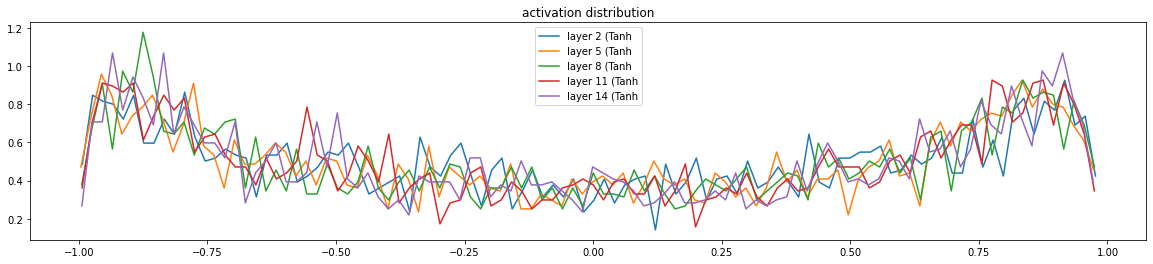

In [34]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (Tanh): mean +0.000000, std 3.682950e-03
layer 5 (Tanh): mean -0.000000, std 3.262606e-03
layer 8 (Tanh): mean -0.000000, std 2.973729e-03
layer 11 (Tanh): mean +0.000000, std 2.741107e-03
layer 14 (Tanh): mean -0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

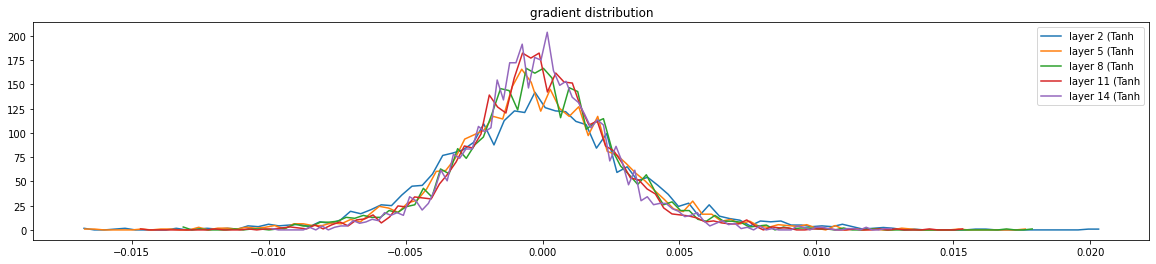

In [35]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.019883e-02 | grad:data ratio 1.018844e-02
weight  (30, 100) | mean +0.000092 | std 8.238419e-03 | grad:data ratio 2.635835e-02
weight (100, 100) | mean +0.000031 | std 7.318100e-03 | grad:data ratio 4.377137e-02
weight (100, 100) | mean -0.000019 | std 6.662020e-03 | grad:data ratio 3.949894e-02
weight (100, 100) | mean -0.000019 | std 5.821514e-03 | grad:data ratio 3.468160e-02
weight (100, 100) | mean +0.000053 | std 5.445292e-03 | grad:data ratio 3.243364e-02
weight  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad:data ratio 6.281257e-02


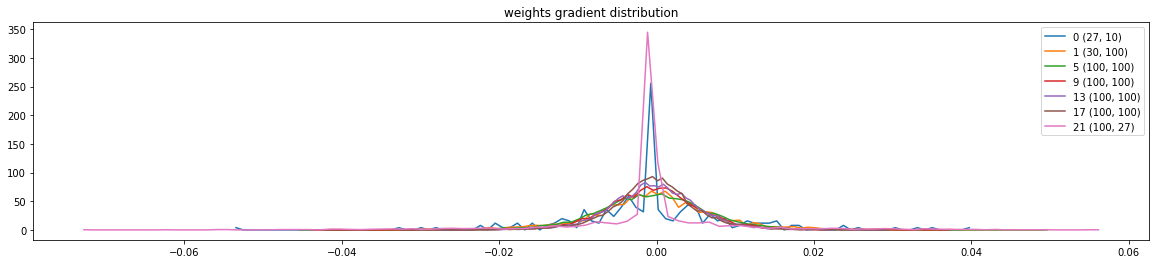

In [36]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # considering only the weights
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

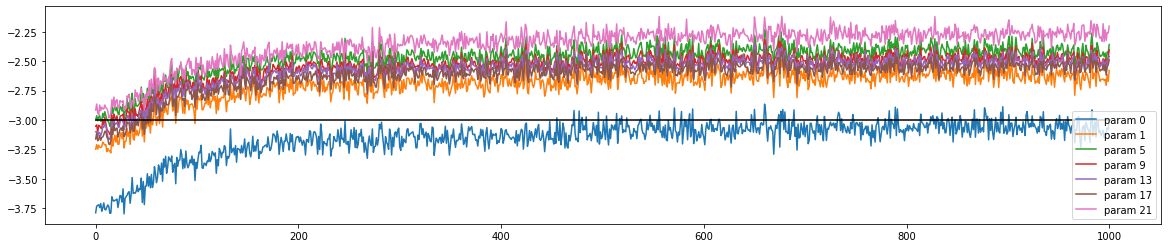

In [37]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [38]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.434417963027954
val 2.4324371814727783


In [39]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpah.
qarlileif.
jmrri.
thty.
sacansa.
jazhntefapliah.
jagqeiu.
ramara.
chriiv.
kalein.
dhlm.
join.
qhijthn.
lilea.
jadbq.
wane.
ogdearyxi.
jaheininsan.
ed.
ecoia.


### Tracking all the loss values:
1. intial values: train 2.1190242767333984 val 2.1616098880767822
2. after fixing high intial loss caused by softmax being confidently wrong by updating W2 and b2: train 2.069324493408203 val 2.133208990097046
3. after fixing tanh saturation: train 2.0343782901763916 val 2.1024086475372314
4. kaiming he intialization: train 2.037754774093628 val 2.1032512187957764
5. batch norm: train 2.065701723098755 val 2.1107821464538574
